In [1]:
import os
import sys
import warnings
import contextlib
from itertools import combinations
from tqdm.notebook import tqdm
from timeit import default_timer as timer

import matplotlib.pyplot as plt
import numpy as np

from neurodsp.spectral import compute_spectrum
from timescales.sim import sim_spikes_synaptic
from timescales.fit import convert_knee_val, fit_psd
from timescales.optimize import fit_grid

# abcTau
sys.path.append('/home/rph/Projects/abcTau')
sys.path.append('/home/rph/Projects/abcTau/abcTau')
import abcTau
from abcTau import distance_functions
from scipy import stats

### Addressing Finite Duration Bias with Grid Search

This notebook examines if hyperparameter gridsearch can be used to minimize finite duration bias. Taking the mean timescale of a grid of parameters significantly reduces finite duration bias. Specifically bias from 1s simulation approaches a comparable timescale variance as from 10s simulations, when the mean of the grid is used. This means that gridsearch may be an alternative to Zeraati 2021, which uses a Bayesian model to reduce bias. Both methods are slow, but direct comparison may be useful to see which method performs better.

The grid could be further explored to determine which hyperparamaters are most useful for reducing bias. Eliminating parameters that aren't useful could speed up computation time or accuracy.

In [2]:
def get_knee(probs, fs):
    
    try:
        freqs, powers = compute_spectrum(probs, fs, f_range=(1, 100))
        _, knee_freq, _ = fit_psd(freqs, powers, (1, 100))
    except:
        get_knee(probs, fs)
        
    return knee_freq

def _fit_grid(sig, fs, grid, max_n_params=int(1e3), return_time=False):
    
    with warnings.catch_warnings():
        
        warnings.simplefilter("ignore")
        
        start = timer()
        params = fit_grid(sig, fs, grid, mode='psd', max_n_params=max_n_params,
                          n_jobs=-1, chunksize=20)
        end = timer()
        
        knees = np.array([p[1] for p in params])
        time = end - start
        
    if return_time:
        return knees, time
    else:
        return knees

In [3]:
n_seconds_params = [1, 10, 100]
fs = 1000
n_iters = 100

knee_freqs = np.zeros((len(n_seconds_params), n_iters))

seed_ind = 0
for ind, n_seconds in enumerate(n_seconds_params):
    
    for n in tqdm(range(n_iters)):
        
        # Generate timeseries
        #   Note: this isn't stored to limit memory usage
        np.random.seed(seed_ind)
        seed_ind += 1
                  
        probs, _ = sim_spikes_synaptic(n_seconds, fs, convert_knee_val(10))
        
        _knee_freq = get_knee(probs, fs)
            
        knee_freqs[ind][n] = _knee_freq

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

### Baseline: No Grid Search

Text(0.5, 0, 'Seconds')

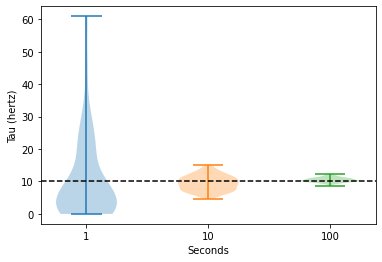

In [4]:
plt.violinplot(knee_freqs[0])

plt.violinplot(knee_freqs[1], positions=[2])

plt.violinplot(knee_freqs[2], positions=[3])

plt.axhline(10, color='k', ls='--')

plt.xticks(ticks=[1, 2, 3], labels=['1', '10', '100'])
plt.ylabel('Tau (hertz)')
plt.xlabel('Seconds')

### Grid Search

In [5]:
specparam_grid = {
    # Init kwargs
    'peak_width_limits': np.array(list(combinations(np.arange(1, 10, 2), 2))),
    'max_n_peaks': np.arange(1, 13, 3),
    'peak_threshold': np.arange(1, 5),
    # Self kwargs (post-init)
    'knee_freq_bounds': np.array([[.1, 20]]),
    'exp_bounds': np.column_stack((np.array([.01, 1, 2]), np.arange(2, 5))),
    # Compute spectra kwargs
    'nperseg': (np.linspace(.5, 1.5, 5) * fs).astype(int),
    'noverlap': np.arange(0, 10, 2)/10,
    # Fit kwargs
    'freq_range': np.array([[0, 100]])
}

In [6]:
fs = 1000
n_iters = 100
max_n_params = int(1e3)

knee_freqs_grid = np.zeros((n_iters, max_n_params))
times = np.zeros(n_iters)

seed_ind = 0
for n in tqdm(range(n_iters), total=n_iters):

    np.random.seed(seed_ind)
    seed_ind += 1

    probs, _ = sim_spikes_synaptic(1, fs, convert_knee_val(10))

    _knee_freq, _time = _fit_grid(probs, fs, specparam_grid, max_n_params=max_n_params,
                                  return_time=True)
    
    knee_freqs_grid[n] = _knee_freq
    times[n] = _time

  0%|          | 0/100 [00:00<?, ?it/s]

Text(0.5, 0, 'Seconds')

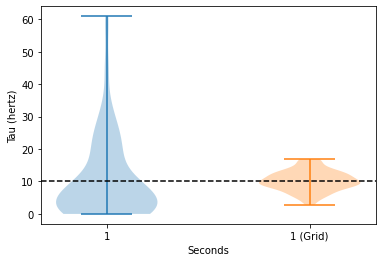

In [7]:
plt.violinplot(knee_freqs[0])

plt.violinplot(knee_freqs_grid.mean(axis=1), positions=[2])

plt.axhline(10, color='k', ls='--')

plt.xticks(ticks=[1, 2], labels=['1', '1 (Grid)'])
plt.ylabel('Tau (hertz)')
plt.xlabel('Seconds')

Text(0.5, 0, 'Seconds')

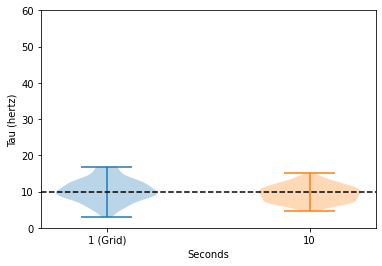

In [8]:
plt.violinplot(knee_freqs_grid.mean(axis=1))

plt.violinplot(knee_freqs[1], positions=[2])

plt.axhline(10, color='k', ls='--')

plt.xticks(ticks=[1, 2], labels=['1 (Grid)', '10'])
plt.ylim(0, 60)
plt.ylabel('Tau (hertz)')
plt.xlabel('Seconds')

### Comparison with abcTau

The random grid search above is compared with the abcTau approach below.

In [9]:
sigs = np.zeros((n_iters, int(fs)))

seed_ind = 0
for n in tqdm(range(n_iters), total=n_iters):

    np.random.seed(seed_ind)
    seed_ind += 1

    probs, _ = sim_spikes_synaptic(1, fs, convert_knee_val(10))
    sigs[n] = probs

  0%|          | 0/100 [00:00<?, ?it/s]

In [10]:
# creating model object
class ABCModel(abcTau.Model):

    #This method initializes the model object.  
    def __init__(self):
        pass
        
    # draw samples from the prior. 
    def draw_theta(self):
        theta = []
        for p in self.prior:
            theta.append(p.rvs())
        return theta

    # Choose the generative model (from generative_models)
    # Choose autocorrelation computation method (from basic_functions)
    def generate_data(self, theta):
        # generate synthetic data
        if disp == None:
            syn_data, numBinData =  eval('abcTau.generative_models.' + generativeModel + \
                                         '(theta, deltaT, binSize, T, numTrials, data_mean, data_var)')
        else:
            syn_data, numBinData =  eval('abcTau.generative_models.' + generativeModel + \
                                         '(theta, deltaT, binSize, T, numTrials, data_mean, data_var, disp)')
               
        # compute the summary statistics
        syn_sumStat = abcTau.summary_stats.comp_sumStat(syn_data, summStat_metric, ifNorm, deltaT, binSize, T,\
                                          numBinData, maxTimeLag)   
        return syn_sumStat

    # Computes the summary statistics
    def summary_stats(self, data):
        sum_stat = data
        return sum_stat

    # Choose the method for computing distance (from basic_functions)
    def distance_function(self, data, synth_data):
        if np.nansum(synth_data) <= 0: # in case of all nans return large d to reject the sample
            d = 10**4
        else:
            d = eval('distance_functions.' +distFunc + '(data, synth_data)')        
        return d
    
    
def fit_abc(ABCModel, sigs, priors, epsilon_0, min_samples, steps,
            min_acceptance_rate, parallel, n_procs, disp):

    taus = np.zeros(len(sigs))
    times = np.zeros(len(sigs))
    
    for ind, sig in tqdm(enumerate(sigs), total=len(sigs)):
        
        _sig = np.array([sig])
        
        # Hack
        global data_mean
        global data_var
        global trial_duration
        global num_trials
        
        # Summary stats
        summary_stats, data_mean, data_var, trial_duration, num_trials =  \
            abcTau.preprocessing.extract_stats(_sig, deltaT, binSize,
                                               summStat_metric, ifNorm, maxTimeLag)
        
        # Fit
        with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
            start = timer()
            abc_results, final_step = abcTau.fit.fit_withABC(ABCModel, summary_stats, priors, inter_save_direc,
                                                             inter_filename, datasave_path, filenameSave, epsilon_0,
                                                             min_samples, steps, min_acceptance_rate, parallel,
                                                             n_procs, disp)
            end = timer()
        
        taus[ind] =  (abc_results[final_step-1][0] / fs).mean()
        times[ind] = end - start
    
    return taus, times

In [11]:
# Setup output directories required for abcTau
def clean_mkdir(path):
    dirs = path.split('/')

    dir_path = ''
    for d in dirs:
        if len(d) == 0:
            continue
        
        if dir_path == '':
            dir_path = d
        else:
            dir_path = dir_path + '/' + d
        
        if not os.path.isdir(dir_path):
            os.mkdir(dir_path)
            

datasave_path = 'abc/example_abc_results/'
inter_save_direc = 'abc/example_abc_results/'
inter_filename = 'abc_intermediate_results'
filenameSave = 'simulation'

for path in [datasave_path, inter_save_direc]:
    clean_mkdir(path)

In [16]:
# abcTau settings
summStat_metric = 'comp_psd'
deltaT = 1
binSize = 1
disp = None 
maxTimeLag = 50
ifNorm = True
generativeModel = 'oneTauOU'
distFunc = 'linear_distance'
epsilon_0 = 1
min_samples = 100
steps = 60
min_acceptance_rate = 0.1
parallel = True
n_procs = 12
numTrials = 1
numTimePoints = len(sigs[0])
T = numTimePoints* deltaT

# Uniform Priors
t_min = 0.0
t_max = 100.0
priors = [stats.uniform(loc=t_min, scale = t_max - t_min)]

In [17]:
# Fit
taus_abs, times_abc = fit_abc(ABCModel, sigs, priors, epsilon_0, min_samples,
                         steps, min_acceptance_rate, parallel, n_procs, disp)

  0%|          | 0/100 [00:00<?, ?it/s]

Text(0.5, 0, 'Method')

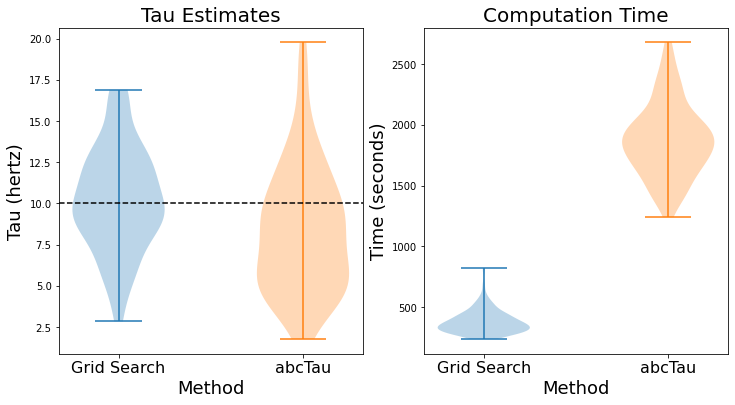

In [32]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))

axes[0].set_title('Tau Estimates', size=20)
axes[0].violinplot(knee_freqs_grid.mean(axis=1))
axes[0].violinplot(convert_knee_val(taus_abs), positions=[2])

axes[0].axhline(10, color='k', ls='--')

axes[0].set_xticks(ticks=[1, 2], labels=['Grid Search', 'abcTau'], size=16)
axes[0].set_ylabel('Tau (hertz)', size=18)
axes[0].set_xlabel('Method', size=18)


axes[1].set_title('Computation Time', size=20)
axes[1].violinplot(times * n_iters)
axes[1].violinplot(times_abc * n_iters, positions=[2])

axes[1].set_xticks(ticks=[1, 2], labels=['Grid Search', 'abcTau'], size=16)
axes[1].set_ylabel('Time (seconds)', size=18)
axes[1].set_xlabel('Method', size=18)